# Imports

In [36]:
import importlib
import functions as f  # Our defined functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

importlib.reload(f)

GRatio = (1 + 5 ** .5) / 2

WIDTH = .5
DASH = (10, 10)


# Solving models

Model verified.
Writing new model to file models/SIS.json.
File name already exists.


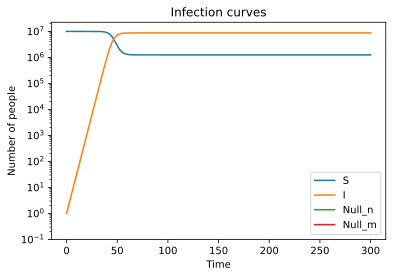

Pop variation: +0


In [37]:
name = 'SIS'
model = f.loadModel(name)
solution, t_span = f.solve(model, (0, 300), 100)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(model))
plt.yscale('log')
plt.ylim(bottom=.1)
plt.show()

print(f"Pop variation: {f.getPopChange(model, solution):+.0f}")


Model verified.
Writing new model to file models/SIR_vars.json.
File name already exists.


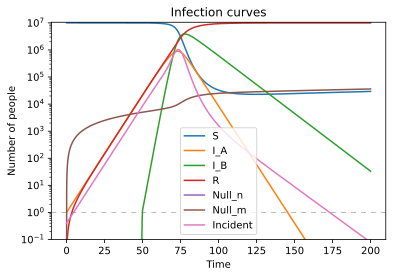

Pop variation: -16178

Creating new model!
New model created in 0.0e+00 seconds.

{'Rt(S,I_A)': 1.997995779327841, 'Rt(S,I_B)': 0.0}


In [38]:
modelName = 'SIR_vars'

model = f.loadModel(modelName)
solution, t_span = f.solve(model, (0, 200), 100)

# SIRS_deaths2 = f.mod(SIRS_deaths)
# solution2, t_span2 = f.solve(SIRS_deaths2, (0, 200), 100)

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(model))
plt.plot(t_span, f.infCurve(model, solution, t_span), label='Incident')
plt.ylim(bottom=.1)
plt.legend(loc='best')
plt.axhline(y=1, linestyle='--', color='grey', linewidth=WIDTH, dashes=DASH)
plt.yscale('log')
plt.show()

popChange = f.getPopChange(model, solution)
print(f"Pop variation: {popChange:.0f}")

f.mod(model)

model, modelMod, _, r0 = f.computeR0(
            modelName, (0, 300), printInit=False, printWarnings=False,
            autoInfections=True, scaledInfs=False, printText=False)

print(r0)

# $\mathcal{R}_t$ curves


Scaled: False, Auto: True
Time difference is not relevant, no intersection between rt and 1.



Scaled: False, Auto: False
0.00133779478194398
0.00133779478194398
Time difference: 0.509999999999998


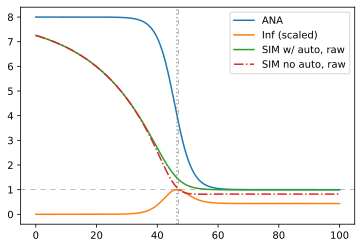

In [47]:
rtCurves = f.allScenarios("SIS", (0, 100), R0=8)


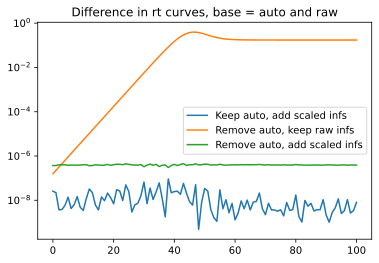

In [48]:
fig = plt.figure()

plt.title('Difference in rt curves, base = auto and raw')
plt.plot(np.abs(rtCurves[0] - rtCurves[1]), label='Keep auto-infs, add scaled infs')
plt.plot(np.abs(rtCurves[0] - rtCurves[2]), label='Remove auto-infs, keep raw infs')
plt.plot(np.abs(rtCurves[0] - rtCurves[3]), label='Remove auto-infs, add scaled infs')

plt.yscale('log')
plt.legend(loc='best')
plt.show()


Scaled: False, Auto: True
0.022757690016432228
0.022757690016432228
Time difference: 1.0300000000000011



Scaled: True, Auto: True
0.005317637043376102
0.005317637043376102
Time difference: 0.46999999999999886



Scaled: False, Auto: False
0.022757690016432228
0.022757690016432228
Time difference: 1.0300000000000011



Scaled: True, Auto: False
0.005317637043376102
0.005317637043376102
Time difference: 0.46999999999999886


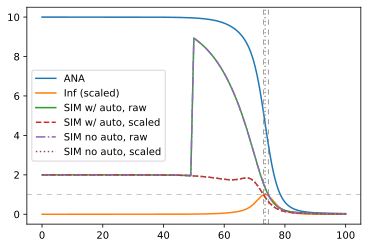

In [41]:
rtCurves = \
    f.allScenarios("SIR_vars", (0, 100), R0=10,
                   autoToPlot=[True, False],
                   scaledToPlot=[False, True])


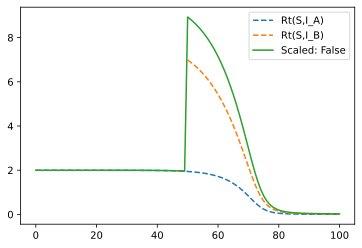

In [42]:
model, newModel, solution, t_span, values = f.computeRt(
    'SIR_vars', (0, 100), sub_rt=1, autoInfections=True,
    scaledInfs=False, write=False, printText=False,
    printInit=False, printWarnings=False)

rt_times = np.array([key for key in values])
rt = np.zeros_like(rt_times, dtype='float64')
for rtNode in f.getRtNodes(f.mod(model, False, False)):
    rt_rtNode = np.array([values[key][rtNode] for key in values])

    idx = np.where(rt_rtNode > 0)
    if len(f.getRtNodes(f.mod(model, False, False))) > 1:
        plt.plot(rt_times[idx], rt_rtNode[idx], label=rtNode, linestyle='--')
    rt += rt_rtNode

idx = np.where(rt > 0)
plt.plot(rt_times[idx], rt[idx], label=f'Scaled: {False}')
plt.legend(loc='best')
plt.show()

{'Rt(S,I)': 7.2552541611613375}


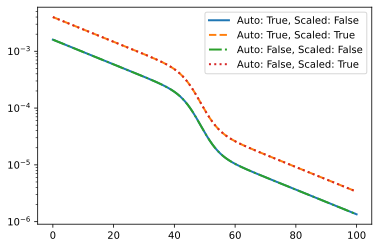

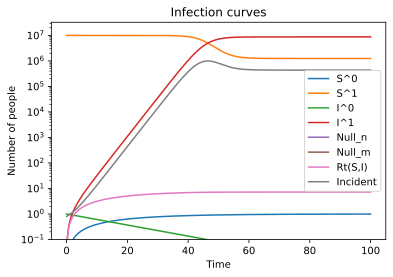

2.9021013742543973 7.2552541611613375


In [43]:
SIS, SISmod, initialConds, R0 = f.computeR0(
    "SIS", write=True, overWrite=True, whereToAdd='contact',
    printInit=False, printText=False)

print(R0)

# modelOld, newModel, solutionOld, t_spanOld, values = f.computeRt(
#     'SIS', (0, 0), whereToAdd='contact', printInit=True)
# f.printModel(values)

i = 0
for auto in [True, False]:
    for scaled in [False, True]:
        newModel = f.mod(SIS, False, auto)

        init = {comp: initialConds[i]
                for i, comp in enumerate(f.getCompartments(SIS))}
        # initialize(newModel, init, modelOld, printText=printInit, whereToAdd=whereToAdd)
        f.initialize(newModel, init, 0, 0, originalModel=SIS,
                     printText=False, whereToAdd='contact',
                     scaled=scaled)

        solution, t_span = f.solve(newModel, (0, 100), 100)
        rts = solution[:, f.getCompartments(newModel).index('Rt(S,I)')]
        s_1 = solution[:, f.getCompartments(newModel).index('S^1')]
        i_0 = solution[:, f.getCompartments(newModel).index('I^0')]

        lw = 2
        ls = ['-', '--', '-.', ':'][i % 4]
        plt.plot(t_span[:-1], rts[1:] - rts[:-1],
                 label=f'Auto: {auto}, Scaled: {scaled}',
                 linestyle=ls, linewidth=lw)
        i += 1
plt.yscale('log')
plt.legend(loc='best')
plt.show()

fig = plt.figure()
f.plotCurves(t_span,
             np.transpose(solution),
             toPlot=list(range(solution.shape[1])),
             labels=f.getCompartments(newModel))
plt.plot(t_span, f.infCurve(newModel, solution, t_span), label='Incident')
plt.yscale('log')
plt.ylim(bottom=.1)
plt.legend(loc='best')
plt.show()

newModel = f.mod(SIS, False, True)
init = {comp: initialConds[i]
        for i, comp in enumerate(f.getCompartments(SIS))}
f.initialize(newModel, init, 0, 0, originalModel=SIS,
             printText=False, whereToAdd='contact',
             scaled=False)
solution, t_span = f.solve(newModel, (0, 100), 100)
rts = solution[:, f.getCompartments(newModel).index('Rt(S,I)')]

print(rts[-1], rts[-1] / f.totInfs(SIS, initialConds, t_span[-1], t_span[-1]))


In [44]:
# Intégration symbolique

# import sympy as sym
# from sympy import exp
# tInt = sym.symbols('tInt')
# func = 'exp(-tInt)'

# sym.init_printing()

# sym.print_latex(sym.integrate(func, tInt))
# sym.print_latex(eval(func))
# sym.print_latex(sym.diff(func))

In [45]:
# Démonstration de stockage

# importlib.reload(f)

# print(f.functions)

# f.storeFunctions(f.loadModel('SIR_vars'))

# print(f.functions)
# print(f.functions['SIR_vars(0, 0)'](1))